In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from numpy.random import multinomial
from scipy.stats import dirichlet

from collections import Counter

In [2]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)


In [3]:
from functools import reduce

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

In [4]:
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    
    plt.title(kwargs.get('title', ''))

1. (3p.) Implement a Dirichlet-multinomial model for dice tossing problem:
    - likelihood as in the lecture
    - prior as in the lecture
    - use all required pdfs from scipy


In [5]:
data = np.array(['A', 'A', 'B', 'A', 'C', 'A', 'A'])

labels, counts = np.unique(data, return_counts=True)

for l, c in zip(labels, counts):
    print(l, ":", c)

A : 5
B : 1
C : 1


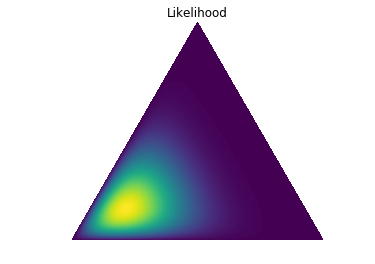

In [6]:
draw_pdf_contours(Dirichlet(counts + 1), title='Likelihood')

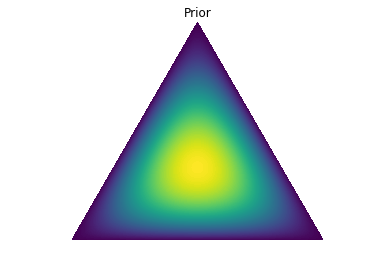

In [7]:
prior = np.array([2, 2, 2])
draw_pdf_contours(Dirichlet(prior), title='Prior')


array([7, 3, 3])

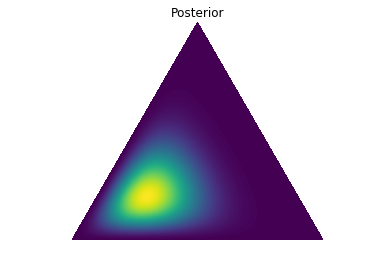

In [8]:
posterior = counts + prior
display(posterior)

draw_pdf_contours(Dirichlet(posterior), title='Posterior')

2. (2p.) Implement a method for posterior predictive distribution of a future observation.
    - appropriate calulation of posterior predictive
    - write example demonstrating prediction

In [9]:
def get_posterior_predictive(counts, prior, labels):
    norm = np.sum(counts) + np.sum(prior)

    return {labels[i]: (c + p) / norm for i, (c, p) in enumerate(zip(counts, prior))}

p_preds = get_posterior_predictive(counts, prior, labels)
p_preds

{'A': 0.53846153846153844, 'B': 0.23076923076923078, 'C': 0.23076923076923078}

In [10]:
n = 1000
multinomial(n, list(p_preds.values())) / n

array([ 0.52 ,  0.245,  0.235])

In [11]:
def predict(p_preds):
    pred = multinomial(1, list(p_preds.values()))
    return list(p_preds.keys())[list(pred).index(1)]

predict(p_preds)

'C'

3. (3p.) Implement prediction mechanism for next word in a text using your model:
    - write apropriate methods for importing 3 sources of textual data: prose, poetry, lyrics (aquire apropriate data in eng. firstly) 
    - for each of them perform simple lematization and stop word elimination (https://stackoverflow.com/questions/38763007/how-to-use-spacy-lemmatizer-to-get-a-word-into-basic-form)
    - provide fair train/test data mechanism for next 'word prediction'
    - test your model on all 3 data types with and without lemmatization, present the results on single chart (choose most appropriate for your case e.g. from seaborn)

In [12]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

text = 'Mary had a little lamb, little lamb, little lamb, Mary had a little lamb, its fleece as white as snow'

nlp = spacy.load('en')
doc = nlp(text)

In [13]:
unknowns = 0
lemmas = []

for token in doc:
    if token.is_stop:
        unknowns += 1
    elif not token.is_punct:
        lemmas.append(token.lemma_)

In [14]:
display(unknowns)
lemmas

7

['mary',
 'little',
 'lamb',
 'little',
 'lamb',
 'little',
 'lamb',
 'mary',
 'little',
 'lamb',
 'fleece',
 'white',
 'snow']

In [15]:
word_counts = Counter(lemmas)
word_counts['unk'] = unknowns

word_counts['big'] = 0
word_counts['black'] = 0
word_counts['rain'] = 0

word_counts

Counter({'big': 0,
         'black': 0,
         'fleece': 1,
         'lamb': 4,
         'little': 4,
         'mary': 2,
         'rain': 0,
         'snow': 1,
         'unk': 7,
         'white': 1})

In [16]:
word_prior = 1

total_words = np.sum(list(word_counts.values()))
total_priors = len(word_counts) * word_prior

denominator = total_priors + total_words

word_dist = {word: (word_prior + count) / denominator for word, count in word_counts.items()}
word_dist

{'big': 0.033333333333333333,
 'black': 0.033333333333333333,
 'fleece': 0.066666666666666666,
 'lamb': 0.16666666666666666,
 'little': 0.16666666666666666,
 'mary': 0.10000000000000001,
 'rain': 0.033333333333333333,
 'snow': 0.066666666666666666,
 'unk': 0.26666666666666666,
 'white': 0.066666666666666666}

In [17]:
predict(word_dist)

'unk'

In [18]:
def lematize_text(text, lematize=True):
    if not lematize:
        return text.split(), 0
    
    nlp = spacy.load('en')
    doc = nlp(text)
    
    unknowns = 0
    lemmas = []
    
    for token in doc:
        if token.is_stop:
            unknowns += 1
        elif not token.is_punct and not token.is_space and not token.is_title:
            lemmas.append(token.text)
            
    return lemmas, unknowns

In [19]:
def get_words_dist(text, word_prior=1, lematize=True):
    lemmas, unknowns = lematize_text(text, lematize)
            
    word_counts = Counter(lemmas)
    word_counts['unk'] = unknowns
    
    total_words = np.sum(list(word_counts.values()))
    total_priors = len(word_counts) * word_prior

    denominator = total_priors + total_words

    return {word: (word_prior + count) / denominator for word, count in word_counts.items()}    

In [20]:
get_words_dist(text, word_prior=1)

{'fleece': 0.083333333333333329,
 'lamb': 0.20833333333333334,
 'little': 0.20833333333333334,
 'snow': 0.083333333333333329,
 'unk': 0.33333333333333331,
 'white': 0.083333333333333329}

In [21]:
train_size = 0.7

In [22]:
with open('texts/macbeth.txt') as f:
    macbeth = f.read()

split_point = int(len(macbeth) * train_size)
macbeth_dist = get_words_dist(macbeth[:split_point])

list(macbeth_dist.items())[:5]

[('ACT', 0.00039610235284797589),
 ('SCENE', 0.0015844094113919036),
 ('desert', 0.00023766141170878554),
 ('place', 0.00087142517626554697),
 ('lightning', 0.00023766141170878554)]

In [23]:
words, _ = lematize_text(macbeth[split_point:])

good = 0

for y in words:
    y_pred = predict(macbeth_dist)
    good += y_pred == y
    
accuracy = good / len(words)
accuracy

0.002234137622877569

In [24]:
def get_model_score(text, train_size=0.7, lematize=True):
    split_point = int(len(text) * train_size)
    text_dist = get_words_dist(text[:split_point], lematize)
    
    words, _ = lematize_text(text[split_point:], lematize)
    good = 0

    for y in words:
        y_pred = predict(text_dist)
        good += y_pred == y

    return good / len(words)

In [29]:
import seaborn as sns

acc_lem = get_model_score(macbeth, lematize=True)
acc_without_lem = get_model_score(macbeth, lematize=False)

ax = sns.barplot(['Lematized', 'Not Lematized'], [acc_lem, acc_without_lem]).set_title('Macbeth')

In [26]:
with open('texts/harry_potter.txt') as f:
    hp = f.read()
    
acc_lem = get_model_score(hp, lematize=True)
acc_without_lem = get_model_score(hp, lematize=False)

ax = sns.barplot(['Lematized', 'Not Lematized'], [acc_lem, acc_without_lem]).set_title('Harry Potter 1 - Sorcerer\'s Stone')


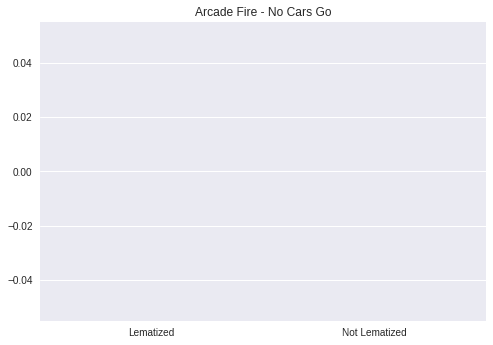

In [27]:
with open('texts/arcade_fire.txt') as f:
    af = f.read()
    
acc_lem = get_model_score(af, lematize=True)
acc_without_lem = get_model_score(af, lematize=False)

ax = sns.barplot(['Lematized', 'Not Lematized'], [acc_lem, acc_without_lem]).set_title('Arcade Fire - No Cars Go')
